In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tf.keras.backend.set_floatx("float64")

In [2]:
# YOUR CODE
import math


def load_img(path_to_img, max_dim):
    image = tf.io.read_file(path_to_img)
    image = tf.io.decode_image(
        image, channels=3, dtype=tf.dtypes.float64, name=None, expand_animations=True
    )
    image = tf.image.convert_image_dtype(image, dtype=tf.float64, saturate=False)

    print("Initial shape: ", image.shape)
    max_dim = max_dim
    image = tf.expand_dims(image, 0)
    height = image.shape[1]
    weight = image.shape[2]
    if height > weight:
        weight = (weight / height) * max_dim
        height = max_dim
    elif weight > height:
        height = (height / weight) * max_dim
        weight = max_dim
    else:
        height = max_dim
        weight = max_dim
    image = tf.image.resize(image, [math.trunc(height), math.trunc(weight)])
    img = tf.cast(image, tf.float64)
    print("Final shape: ", image.shape)

    return img

In [7]:
# YOUR CODE
content_image = load_img("cont_art.jpg", 1024)
style_image = load_img("fish.png", 1024)

Initial shape:  (608, 1080, 3)
Final shape:  (1, 576, 1024, 3)
Initial shape:  (3287, 2176, 3)
Final shape:  (1, 1024, 677, 3)


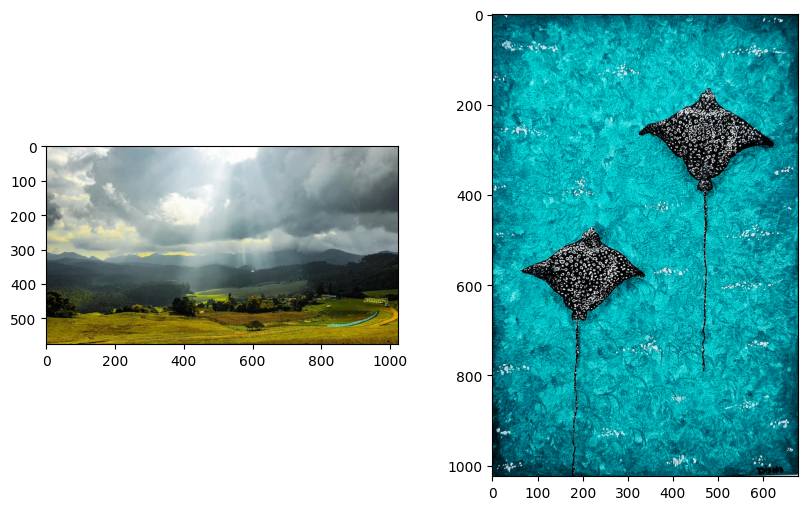

In [8]:
# YOUR CODE
# you can give axis attribute if you wanna squeeze in specific dimension
content = np.squeeze(content_image)
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(content)
style = np.squeeze(style_image)
plt.subplot(1, 2, 2)
plt.imshow(style)
plt.show()

In [5]:
# YOUR CODE
vgg = tf.keras.applications.VGG19(include_top=True, weights="imagenet")

In [8]:
# YOUR CODE
tf.keras.models.Model.summary(vgg)

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
# YOUR CODE


def preprcoess_input(data):
    image =  tf.keras.applications.vgg19.preprocess_input(tf.cast(data*255, dtype= tf.int64), data_format=None)
    rescale_image = tf.image.resize(image,[vgg.layers[0].get_output_at(0).get_shape()[1],vgg.layers[0].get_output_at(0).get_shape()[2]])
    return image,rescale_image


processed_input = preprcoess_input(content_image)
content_image_pp = processed_input[0]
content_image_rs = processed_input[1]



In [10]:
predicted_probabilities = vgg(content_image_rs)

In [11]:
predicted_top_10 = tf.keras.applications.vgg19.decode_predictions(
    predicted_probabilities.numpy(), top=10
)

In [12]:
[(class_name, prob) for (number, class_name, prob) in predicted_top_10[0]]

[('boathouse', 0.42790015440816315),
 ('lakeside', 0.4200839698361863),
 ('sandbar', 0.024289344820093265),
 ('castle', 0.015384411384073775),
 ('seashore', 0.013199417707359747),
 ('canoe', 0.012778530149571093),
 ('pier', 0.009301018125655635),
 ('valley', 0.00886326430839344),
 ('paddle', 0.008282854066534397),
 ('palace', 0.006498543253735676)]

In [13]:
# YOUR CODE
processed_input_style = preprcoess_input(style_image)
style_image_pp = processed_input_style[0]
style_image_rs = processed_input_style[1]
predicted_probabilities_style = vgg(style_image_rs)
predicted_top_10_style = tf.keras.applications.vgg19.decode_predictions(
    predicted_probabilities_style.numpy(), top=10
)


In [14]:
[(class_name, prob) for (number, class_name, prob) in predicted_top_10_style[0]]

[('wreck', 0.21031617099028907),
 ('pot', 0.13426851437902781),
 ('bathtub', 0.051166029661041675),
 ('tub', 0.05079707571495608),
 ('vase', 0.021381263204052915),
 ('bucket', 0.02088846242566447),
 ('cup', 0.018786658141656448),
 ('shovel', 0.01800541744782253),
 ('seashore', 0.01691518827530016),
 ('sandbar', 0.01419750986638575)]

In [15]:
# YOUR CODE
vgg_false = tf.keras.applications.VGG19(include_top=False, weights="imagenet")

In [17]:
for i in vgg_false.layers:
    print(i.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


**Checkpoint:** Your output should look as follows:
```
input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
```

This output includes all layers, that can be added to $L_\mathrm{content}$ and $L_\mathrm{style}$. For the moment, let us fix the following:

11. Create two lists ```content_layers``` and ```style_layers```. Initialize ```content_layers``` with a single element ```"block4_conv2"``` and ```style_layers``` with five elements ```"block1_conv1", ..., "block5_conv1"```.

In [19]:
# YOUR CODE
content_layers = ["block3_conv4"]
style_layers = [
    "block1_conv2",
    "block2_conv2",
    "block3_conv2",
    "block4_conv2",
    "block5_conv2",
]
#content_layers = ["block4_conv2"]
#style_layers = [    "block1_conv1",    "block2_conv1",    "block3_conv1",
   # "block4_conv1",
   # "block5_conv1",
#]

In [20]:
# YOUR CODE
def vgg_layers(layer_names):
    output_layer = []
    for i in layer_names:
        output_layer.append(vgg_false.get_layer(i).output)
    model = tf.keras.Model([vgg_false.input], output_layer)
    return model

In [21]:
vgg_layers(style_layers).output

[<KerasTensor: shape=(None, None, None, 64) dtype=float64 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float64 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float64 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float64 (created by layer 'block4_conv2')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float64 (created by layer 'block5_conv2')>]

In [22]:
# YOUR CODE
def gram_matrix(input_tensor):
    e = tf.linalg.einsum("xijc,xijs->xcs", input_tensor, input_tensor)
    #     e = tf.linalg.einsum("xijc,xjks->xcs", input_tensor, input_tensor)
    input_shape = tf.cast(tf.shape(input_tensor), dtype=tf.float64)
    #     print(input_shape)
    return e / (input_shape[1] * input_shape[2] * input_shape[3])

In [23]:
gram_matrix(vgg_layers(style_layers)(content_image)[0])

<tf.Tensor: shape=(1, 64, 64), dtype=float64, numpy=
array([[[0.01812967, 0.01665608, 0.10379924, ..., 0.01536286,
         0.01111809, 0.00954304],
        [0.01665608, 0.01759887, 0.10804233, ..., 0.01640308,
         0.0114482 , 0.00969336],
        [0.10379924, 0.10804233, 1.08391622, ..., 0.1075996 ,
         0.11953383, 0.07287436],
        ...,
        [0.01536286, 0.01640308, 0.1075996 , ..., 0.02184817,
         0.01577615, 0.01081378],
        [0.01111809, 0.0114482 , 0.11953383, ..., 0.01577615,
         0.02137855, 0.00911751],
        [0.00954304, 0.00969336, 0.07287436, ..., 0.01081378,
         0.00911751, 0.00674995]]])>

In [24]:
# replace all occurences of None
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs * 255)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (
            outputs[: self.num_style_layers],
            outputs[self.num_style_layers :],
        )
        style_outputs = [gram_matrix(i) for i in style_outputs]
        content_dict = {
            content_name: value
            for content_name, value in zip(self.content_layers, content_outputs)
        }
        style_dict = {
            style_name: value
            for style_name, value in zip(self.style_layers, style_outputs)
        }
        return {"content": content_dict, "style": style_dict}

In [25]:
# YOUR CODE
extractor = StyleContentModel(style_layers, content_layers)

In [26]:
extractor

In [ ]:
# YOUR CODE
# style_targets = extractor(style_image)
style_targets = extractor(style_image)['style']


In [ ]:
style_targets["block4_conv2"]

In [ ]:
# YOUR CODE
content_targets = extractor(content_image)["content"]

In [ ]:
content_targets["block5_conv4"][0][0]

In [ ]:
# YOUR CODE
image = tf.Variable(content_image)

In [33]:
# YOUR CODE
content_weight = 1e3
style_weight = 1e-2

20. Assign the optimizer ```tf.optimizers.Adam``` with parameters ```learning_rate=0.02```, ```beta_1=0.99``` and ```epsilon=1e-1``` to ```opt```.

In [34]:
# YOUR CODE
opt = tf.optimizers.experimental.Nadam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [35]:
opt

In [36]:
# # YOUR CODE
# def clip_0_1(image):
#     values = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
#     return values
# YOUR CODE
def clip_0_1(image):
    values = tf.clip_by_value(image, 0, 1)
    return values

In [37]:
# replace all occurences of None
def style_content_loss(
    outputs, style_targets, content_targets, style_weight, content_weight
):
    style_outputs = outputs["style"]
    content_outputs = outputs["content"]

    style_loss = tf.add_n(
        [
            tf.reduce_sum((style_outputs[name] - style_targets[name]) ** 2)
            for name in style_outputs.keys()
        ]
    )
    style_loss *= style_weight / (4 * len(style_outputs))
    content_loss = tf.add_n(
        [
            tf.reduce_sum((content_outputs[name] - content_targets[name]) ** 2)
            for name in content_outputs.keys()
        ]
    )
    content_loss *= content_weight / (2 * len(content_outputs))
    loss = style_loss + content_loss
    return loss

In [40]:
# replace all occurences of None
@tf.function()
def train_step(image, opt):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(
                        outputs=outputs,
            style_targets=style_targets,
            content_targets=content_targets,
            style_weight=style_weight,
            content_weight=content_weight,
        )
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    return loss

In [ ]:
loops = 200
iters_per_loop = 12

file_writer = tf.summary.create_file_writer(
    "logs" + f"/stw{style_weight}_cow{content_weight}" + "my_image"
)
file_writer.set_as_default()

for loop in range(loops):
    tf.summary.image("image", data=image, step=loop * iters_per_loop)
    for it in range(iters_per_loop):
        # YOUR CODE
        loss = train_step(image, opt)
        tf.summary.scalar("loss", data=loss, step=loop * iters_per_loop + it)

25. Initialize ```tv_weight = 1e3```.

In [ ]:
# YOUR CODE
tv_weight = 1e3

26. Redefine ```train_step```. The only difference above should be an additional loss term ```tv_weight * tf.cast(tf.image.total_variation(image)[0], tf.float64)```.

In [ ]:
# YOUR CODE

# replace all occurences of None
@tf.function()
def train_step(image, opt):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(
            outputs=outputs,
            style_targets=style_targets,
            content_targets=content_targets,
            style_weight=style_weight,
            content_weight=content_weight,
        ) + tv_weight * tf.cast(tf.image.total_variation(image)[0], tf.float64)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    return loss

27. Initialize ```image``` again.

In [ ]:
# YOUR CODE
image = tf.Variable(content_image)

28. Repeat step 24. and view the results. Don't forget to re-initialize ```opt```.

In [ ]:
# YOUR CODE
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
loops = 100
iters_per_loop = 10

file_writer = tf.summary.create_file_writer(
    "logs" + f"/stw{style_weight}_cow{content_weight}" + "tv_weights_my_image"
)
file_writer.set_as_default()

for loop in range(loops):
    tf.summary.image("image", data=image, step=loop * iters_per_loop)
    for it in range(iters_per_loop):
        # YOUR CODE
        loss = train_step(image, opt)
        tf.summary.scalar("loss", data=loss, step=loop * iters_per_loop + it)

29. Submit this notebook not later than December 11th.

30. Apply Neural Style Transfer to content and style images of your choice. Three (not more and not less) self-created images per group need to be submitted and are also due on Decmeber 11th.

The submitted images are intended to participate in a *Neural Art Contest* that will take place towards the end of the semester in the form of a public online poll. The guiding theme of the contest is *Nature*. So your content images should feature something from this context. Apart from using content and style images of your choice, there are several things you could try:

- Use a larger value of ```max_dim``` to produce higher-resolution images.
- Use constant or random initialization for ```image``` instead of ```content_image```.
- Use lists ```content_layers``` and ```style_layers``` that are different from the standard setting.
- Modify ```content_weight```, ```style_weight``` and ```tv_weight```.
- Replace ```tf.optimizers.Adam``` by another algorithm.
- Perform more iterations.
- Anything else that comes to your mind.

Importantly, you need to use your own code to create the images. Moreover, your submission needs to be reproducible, i.e., you are asked to submit all content, style and generated images Python scripts that can be run to reproduce your submitted images.

We recommend to use the GPU cluster, especially when you increase the image resolution.

In [ ]:
import tensorflow as tf

print(tf.__version__)
print(len(tf.config.list_physical_devices("GPU")) > 0)

In [ ]:
##New Images
content_image = load_img("__disha_chauhan__/content/cont_boat.jpg", 1024 )
style_image = load_img("__disha_chauhan__/boat.jpg", 1024 )
